In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [2]:
# Define dataset path
dataset_path = "Dataset\processed_images"

# Image transformations (Normalization & Augmentation)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to fit CNN
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load dataset
train_dataset = ImageFolder(root=dataset_path, transform=transform)
train_size = int(0.8 * len(train_dataset))  # 80% Training
val_size = len(train_dataset) - train_size  # 20% Validation
train_data, val_data = torch.utils.data.random_split(train_dataset, [train_size, val_size])


<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
C:\Users\Lakshmi Khetawat\AppData\Local\Temp\ipykernel_1584\2769804887.py:2: SyntaxWarning: invalid escape sequence '\p'
  dataset_path = "Dataset\processed_images"


In [3]:
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

# Get class names
class_names = train_dataset.classes
num_classes = len(class_names)
print(f"Classes: {class_names}")


Classes: ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


In [4]:
# Define CNN Model
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 28 * 28, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(x.shape[0], -1)  # Flatten
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Initialize model
model = CNNModel(num_classes=num_classes).to(device)
print(model)

CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)


In [5]:
# Define loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch [1/20] | Train Loss: 0.9886 | Train Acc: 0.6690 | Val Loss: 0.7953 | Val Acc: 0.7260
Epoch [2/20] | Train Loss: 0.8717 | Train Acc: 0.6971 | Val Loss: 0.9495 | Val Acc: 0.6685
Epoch [3/20] | Train Loss: 0.8158 | Train Acc: 0.7184 | Val Loss: 0.7243 | Val Acc: 0.7671
Epoch [4/20] | Train Loss: 0.7278 | Train Acc: 0.7569 | Val Loss: 0.8498 | Val Acc: 0.7096
Epoch [5/20] | Train Loss: 0.7674 | Train Acc: 0.7473 | Val Loss: 0.7558 | Val Acc: 0.7425
Epoch [6/20] | Train Loss: 0.6598 | Train Acc: 0.7706 | Val Loss: 0.7160 | Val Acc: 0.7671
Epoch [7/20] | Train Loss: 0.5945 | Train Acc: 0.7919 | Val Loss: 0.7851 | Val Acc: 0.7589
Epoch [8/20] | Train Loss: 0.5852 | Train Acc: 0.7953 | Val Loss: 0.7256 | Val Acc: 0.7507
Epoch [9/20] | Train Loss: 0.6021 | Train Acc: 0.8001 | Val Loss: 0.6259 | Val Acc: 0.8137
Epoch [10/20] | Train Loss: 0.5058 | Train Acc: 0.8297 | Val Loss: 0.5738 | Val Acc: 0.8274
Epoch [11/20] | Train Loss: 0.4634 | Train Acc: 0.8338 | Val Loss: 0.5481 | Val Acc: 0.82

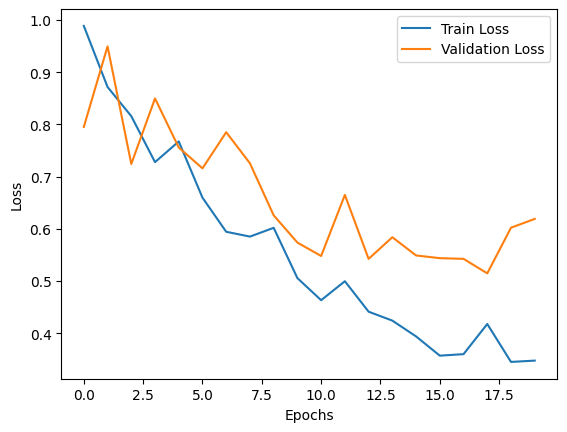

In [8]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20):
    train_losses, val_losses = [], []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        
        train_acc = correct / total
        train_losses.append(running_loss / len(train_loader))

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_acc = val_correct / val_total
        val_losses.append(val_loss / len(val_loader))

        print(f"Epoch [{epoch+1}/{epochs}] | "
              f"Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_acc:.4f}")
    
    # Plot loss curves
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20)



Generating Confusion Matrix...
Validation Accuracy: 0.8329 (83.29%)


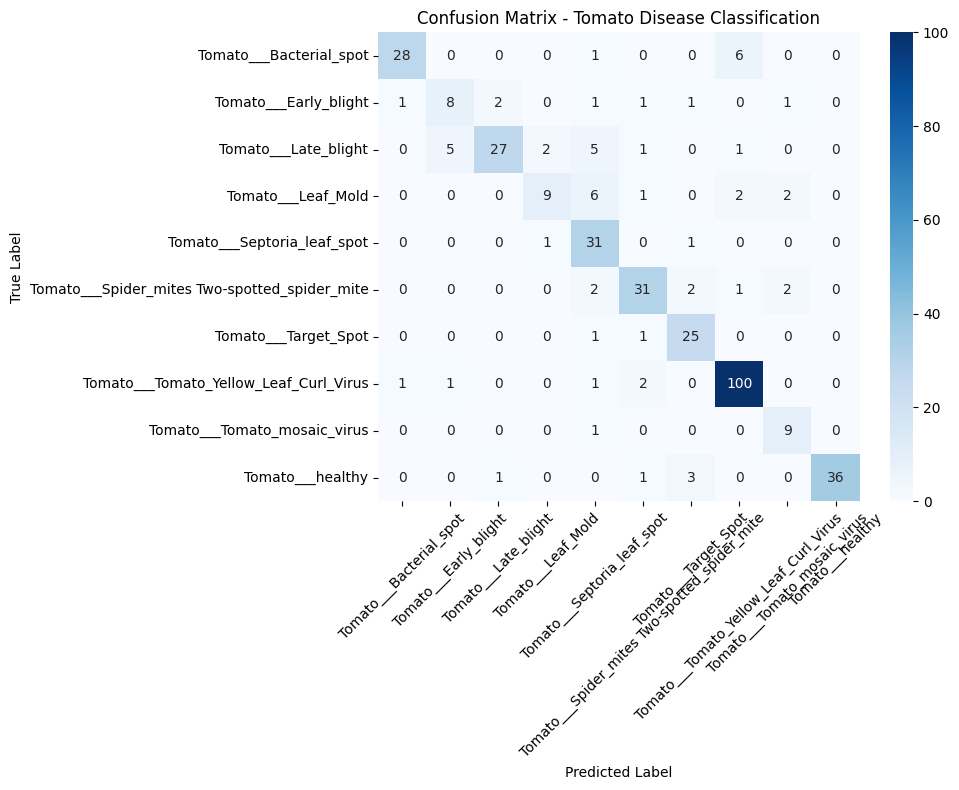


Classification Report:
                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.93      0.80      0.86        35
                        Tomato___Early_blight       0.57      0.53      0.55        15
                         Tomato___Late_blight       0.90      0.66      0.76        41
                           Tomato___Leaf_Mold       0.75      0.45      0.56        20
                  Tomato___Septoria_leaf_spot       0.63      0.94      0.76        33
Tomato___Spider_mites Two-spotted_spider_mite       0.82      0.82      0.82        38
                         Tomato___Target_Spot       0.78      0.93      0.85        27
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.91      0.95      0.93       105
                 Tomato___Tomato_mosaic_virus       0.64      0.90      0.75        10
                             Tomato___healthy       1.00      0.88      0.94        41

                 

In [9]:
# Add these imports at the top of your file
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Add this code after your training is complete
print("\nGenerating Confusion Matrix...")

# Generate predictions on validation set
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Create confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Calculate accuracy
accuracy = (np.array(all_predictions) == np.array(all_labels)).mean()
print(f"Validation Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Tomato Disease Classification')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, target_names=class_names))

# Save the trained model
torch.save(model.state_dict(), "tomato_disease_model.pth")
print("Model saved successfully!")